In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as fftpack
import time
import cmath

In [2]:
'''
Fourier transform functions move between the pattern on the SLM (the `hologram'
plane, H) to the light field in of the trap ('fourier' plane, F).
'''

def fft_HtoF(H):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(H)))

def ifft_FtoH(F):
    return np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(F)))

In [40]:
'''
Import pre-calculated SLM patterns from the data folder.
'''

i = complex(0,1)

def str_to_arg(complex_str):
    return cmath.phase( complex( complex_str.replace('i','j') ) )
def str_to_amp(complex_str):
    return np.abs( complex( complex_str.replace('i','j') ) )
str_to_arg_vec = np.vectorize(str_to_arg)
str_to_amp_vec = np.vectorize(str_to_amp)

phis_on_naomi =  str_to_arg_vec( np.genfromtxt('data/holog_1trap.csv', dtype=str, delimiter=',') )
result_naomi =  str_to_amp_vec( np.genfromtxt('data/obtained_1trap.csv', dtype=str, delimiter=',') )
target_naomi =  str_to_amp_vec( np.genfromtxt('data/target_1trap.csv', dtype=str, delimiter=',') )

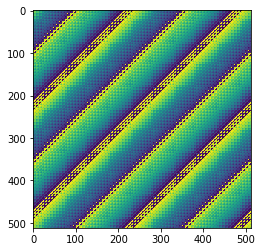

In [30]:
'''
The SLM controls the phase of the pixels in the hologram plane, so we
initialise the amplitudes to random values.
'''

amps_on = np.full((512,512), 1)
phis_on = phis_on_naomi

slm_on = amps_on*np.exp(i*phis_on)

plt.imshow(phis_on)

0.019695043563842773


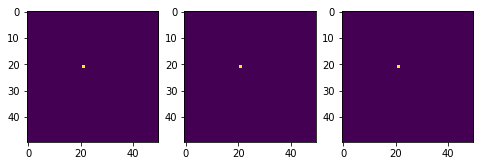

In [31]:
'''
Transform the slm pattern to the fourier plane and compare the produced
pattern to:
    - what was calculated to be the patterns output elsewhere
    - the targeted trap to which the slm pattern was optimised to best
      reproduce.
'''

t1=time.time()
slm_out = fft_HtoF(slm_on)
#slm_out = fftpack.fft2(slm_on)
print(time.time()-t1)

sub_array_size = (50,50)
dx,dy = [int(x/2) for x in sub_array_size]

plt.figure(figsize=(8,3))
plt.subplot(1, 3, 1)
plt.imshow(np.abs(slm_out[256-dx:256+dx,256-dy:256+dy])**1)

plt.subplot(1, 3, 2)
plt.imshow(result_naomi[
            256-dx:256+dx,
            256-dy:256+dy]
           )

plt.subplot(1, 3, 3)
plt.imshow(target_naomi[
            256-dx:256+dx,
            256-dy:256+dy]
           )

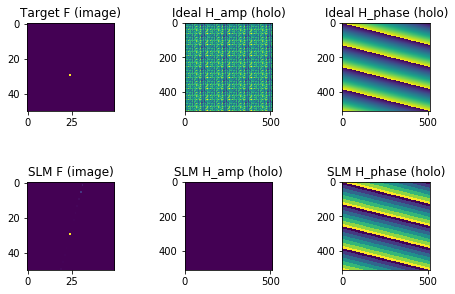

In [32]:
'''
Compare optimised pattern (both phase and amplitude) and its output to that
actually obtained from the slm.
'''

# Rounds a value to the nearest value that can be represented on the 256-bit
# slm pixels.
def myround(x,base=2*np.pi/256):
  return np.round(base * np.round(x/base))

#F_target = get_single_trap_target(5,5)
#H_target = ifft_FtoH(F_target)

H_target = ifft_FtoH(np.roll(np.roll(target_naomi,4,axis=1),1))
F_target = fft_HtoF(H_target)

phase_vec = np.vectorize(cmath.phase)

H_phase = phase_vec(H_target)
H_amp = np.abs(H_target)

H_amp_slm = np.full((512,512), 1)
H_phase_slm = myround(H_phase)

H_slm = H_amp_slm * np.exp(i*H_phase_slm)
F_slm = fft_HtoF(H_slm)

plt.figure(figsize=(8,6))
plt.subplot(2, 3, 1)
plt.imshow(np.abs(F_target[
                    256-dx:256+dx,
                    256-dy:256+dy])**1
           )
plt.title("Target F (image)")

plt.subplot(2, 3, 2)
plt.imshow(H_amp
                    # 256-dx:256+dx,
                    # 256-dy:256+dy]
           )
plt.title("Ideal H_amp (holo)")

plt.subplot(2, 3, 3)
plt.imshow(H_phase
                    # 256-dx:256+dx,
                    # 256-dy:256+dy]
           )
plt.title("Ideal H_phase (holo)")

plt.subplot(2, 3, 4)
plt.imshow(np.abs(F_slm[
                    256-dx:256+dx,
                    256-dy:256+dy])**1
           )
plt.title("SLM F (image)")

plt.subplot(2, 3, 5)
plt.imshow(H_amp_slm
                    # 256-dx:256+dx,
                    # 256-dy:256+dy]
           )
plt.title("SLM H_amp (holo)")

plt.subplot(2, 3, 6)
plt.imshow(H_phase_slm
                    # 256-dx:256+dx,
                    # 256-dy:256+dy]
           )
plt.title("SLM H_phase (holo)")

plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)

plt.show()

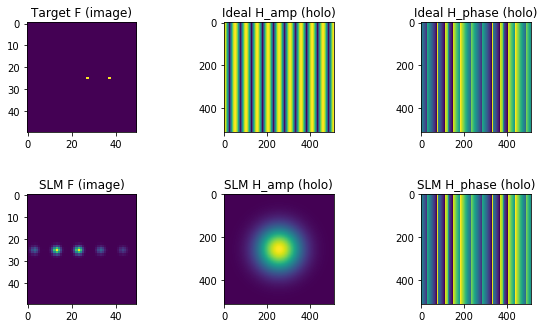

In [33]:
'''
We now move to more physically realistic scenarios.  Here we:
    - define the location of the traps we want to produce,
    - perform a single mapping from the target (fourier) plane to the slm
      (hologram) plane,
    - replace the idealised amplitudes with a gaussian intensity distribution
      of a laser,
    - compare the patterns produced after this 'single-step' optimisation to
      the target traps.
'''

def myround(x,base=2*np.pi/256.0):
  return base * np.round(x/base)

def get_n_traps_target(pos_list):
    F = np.full((512,512), 0)
    for x,y in pos_list:
        F[256+y,256+x]=1
    return F

def gaussian_2d(size, sigma):
    d = int(size/2)
    
    x, y = np.mgrid[-d:d+1, -d:d+1]
    g = np.exp(-(x**2+y**2)/(2*sigma**2))
    return g / g.max()

def add_gaussian_beam(H, pos, size, sigma):
    d = int(size/2)
    if type(pos)==list: pos = np.array(pos)
    xmin,ymin = np.clip(pos-d,-256,256)
    xmax,ymax = np.clip(pos+d+1,-256,256)
    
    g = gaussian_2d(size, sigma)

    H=H.astype(float)

    H[256+xmin:256+xmax,256+ymin:256+ymax] = g
    
    return H

phase_vec = np.vectorize(cmath.phase)

F_target = get_n_traps_target([(0,0),(10,0)])

F_target = np.roll(F_target,2)

H_target = ifft_FtoH(F_target)

H_phase = phase_vec(H_target)
H_amp = np.abs(H_target)

H_amp_slm = np.full((512,512), 0)
H_amp_slm = add_gaussian_beam(H_amp_slm, [0,0], 510, 70)
# H_amp_slm = add_gaussian_beam(H_amp_slm, [128,128], 510/2, 50)
# H_amp_slm = add_gaussian_beam(H_amp_slm, [-128,-128], 510/2, 50)
# H_amp_slm = add_gaussian_beam(H_amp_slm, [128,-128], 510/2, 50)
# H_amp_slm = add_gaussian_beam(H_amp_slm, [-128,128], 510/2, 50)

H_phase_slm = myround(H_phase)

H_slm = H_amp_slm * np.exp(i*H_phase_slm)
F_slm = fft_HtoF(H_slm)

plt.figure(figsize=(10,5))
plt.subplot(2, 3, 1)
plt.imshow(np.abs(F_target[
                    256-dx:256+dx,
                    256-dy:256+dy])**1
           )
plt.title("Target F (image)")

plt.subplot(2, 3, 2)
plt.imshow(H_amp
                    # 256-dx:256+dx,
                    # 256-dy:256+dy]
           )
plt.title("Ideal H_amp (holo)")

plt.subplot(2, 3, 3)
plt.imshow(H_phase
                    # 256-dx:256+dx,
                    # 256-dy:256+dy]
           )
plt.title("Ideal H_phase (holo)")

plt.subplot(2, 3, 4)
plt.imshow(np.abs(F_slm[
                    256-dx:256+dx,
                    256-dy:256+dy])**1
           )
plt.title("SLM F (image)")

plt.subplot(2, 3, 5)
plt.imshow(H_amp_slm
                    # 256-dx:256+dx,
                    # 256-dy:256+dy]
           )
plt.title("SLM H_amp (holo)")

plt.subplot(2, 3, 6)
plt.imshow(H_phase_slm
                    # 256-dx:256+dx,
                    # 256-dy:256+dy]
           )
plt.title("SLM H_phase (holo)")

plt.subplots_adjust(left=0.2, wspace=0.8, top=1.)

plt.show()

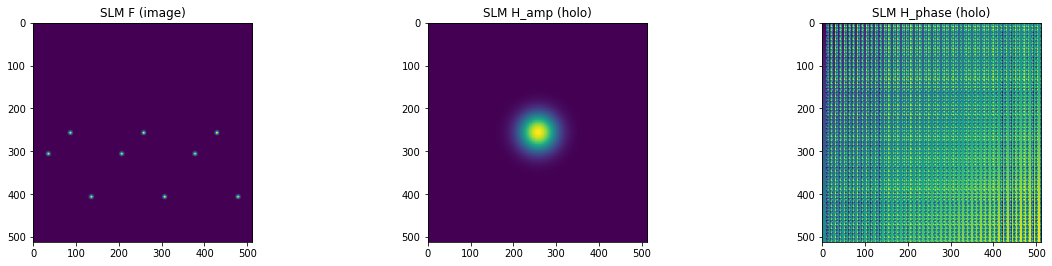

In [197]:
'''
So from the above we have learn that 'single-step' optimisation works quite
well for single-trap patterns, however it is not good enough for generating
multiple traps.

We now take a new (and ultimately better) approach.  We dither multiple
'single-step' slm patterns for single-traps across rows/columns of the slm.

e.g. for n traps we might get slm patterns F1, F2, F3,...,Fn, of the form

                Fi = [ F1_11, F1_12, F1_13, ...
                       F1_21, F1_22, F1_23, ...
                       F1_31, F1_32, F1_33, ...
                       ...,
                                               ].
    So the pattern we would put to the slm to produce traps in all n locations
    would be:

 Fi = [ F1_11, F2_12, F3_13, ...,  Fn_1n, | F1_1(n+1), F2_1(n+2), ... | F1_1(2n+1), ...
        F1_21, F2_22, F3_23, ...,  Fn_2n, | F1_2(n+1), F2_1(n+2), ... | F1_1(2n+1), ...
        F1_31, F2_32, F3_33, ...,  Fn_3n, | F1_3(n+1), F2_1(n+2), ... | F1_1(2n+1), ...
        ...,
                                                                                       ].
                                                                                       
    In this way we effectively use a single MxN pixel slm as multiple
    (M/n)x(N/n) slms, each producing a single trap.
'''

def slm_phase_round(x,base=2*np.pi/256.0):
  return base * np.round(x/base)

'''
Define traps and make individual holo. planes
'''
nCycle_xyShifts = [(1,1),(50,150),(-50,50)]
n_traps = len(nCycle_xyShifts)

phase_grads = []
for nCycle_xyShift in nCycle_xyShifts:
    phase_grad_shifts = [2*np.pi*np.mod(np.arange(0,nCycle,nCycle/512),1)
                                            for nCycle in nCycle_xyShift]
    phase_grads.append([np.tile(phase_grad,(512,1)) 
                        for phase_grad in phase_grad_shifts])
    
#H_phase_grad = H_phase*phase_grad
H_phase_grads = [slm_phase_round(phase_grad_xShift + phase_grad_yShift.transpose())
                 for phase_grad_xShift, phase_grad_yShift in phase_grads]

H_phase_slm = H_phase_grads[0]

'''
Dither traps alternatley in x and y
'''
# k_max = int(np.ceil(len(H_phase_grads[1:])/2))
# l_max = k_max
# k,l=0,0
# 
# for H1, H2 in itertools.zip_longest( H_phase_grads[1::2], H_phase_grads[2::2] ):
#     if type(H1)==np.ndarray:
#         H_phase_slm[:,k::k_max+1] = H1[:,k::k_max+1]
#         k+=1
# 
#     if type(H2)==np.ndarray:
#         H_phase_slm[l::l_max+1,:] = H2[l::l_max+1,:]
#         l+=1

'''
Dither traps in x only
'''
k_max = int(np.ceil(len(H_phase_grads[1:])))     
for H in H_phase_grads[1:]:
    H_phase_slm[:,k::k_max+1] = H[:,k::k_max+1]
    k+=1

'''
Define SLM amplitude profile.
'''
H_amp_slm = add_gaussian_beam(H_amp_slm, [0,0], 510, 30)
# H_amp_slm = add_gaussian_beam(H_amp_slm, [128,128], 510/2, 30)
# H_amp_slm = add_gaussian_beam(H_amp_slm, [-128,-128], 510/2, 30)
# H_amp_slm = add_gaussian_beam(H_amp_slm, [128,-128], 510/2, 30)
# H_amp_slm = add_gaussian_beam(H_amp_slm, [-128,128], 510/2, 30)

'''
Define map holo plane --> image plane
'''
H_slm = H_amp_slm * np.exp(i*H_phase_slm)
F_slm = fft_HtoF(H_slm)

'''
Produce plots
'''
plt.figure(figsize=(20,15))

plt.subplot(1, 3, 1)
plt.imshow(np.abs(F_slm)
                    # 256-100:256+100,
                    # 256-100:256+100])**1
           )
plt.title("SLM F (image)")

plt.subplot(1, 3, 2)
plt.imshow(H_amp_slm
                    # 256-dx:256+dx,
                    # 256-dy:256+dy]
           )
plt.title("SLM H_amp (holo)")

plt.subplot(1, 3, 3)
plt.imshow(H_phase_slm
                    # 256-dx:256+dx,
                    # 256-dy:256+dy]
           )
plt.title("SLM H_phase (holo)")

plt.subplots_adjust(left=0.2, wspace=0.8, top=1)

plt.show()

[[150  50]
 [101 101]
 [ 77  77]]
[1884.8894578665963, 1884.8846353690226, 1.0053289094351829]


<Container object of 3 artists>

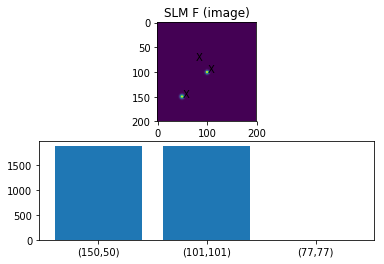

In [195]:
'''
We want the traps to have equal powers which we check here.
The conclusion - I think - is that dithering in rows/columns only gives a more
even power distribution than dithering within 2d pixel blocks.
'''
from skimage.feature import peak_local_max

F_abs = np.abs(F_slm)[256-100:256+100,256-100:256+100]

trap_pos = peak_local_max(F_abs,
                          min_distance=5, num_peaks=n_traps)

fig, (ax1, ax2) = plt.subplots(2,1)

ax1.imshow(F_abs)
for pos in trap_pos:
    ax1.annotate('X',xy=np.flip(pos,axis=0), xycoords='data')
ax1.set_title("SLM F (image)")


print(trap_pos)

trap_amps = [F_abs[x,y] for x,y in trap_pos]
print(trap_amps)

ax2.bar(range(n_traps), trap_amps, tick_label=["({0},{1})".format(*pos) for pos in trap_pos])

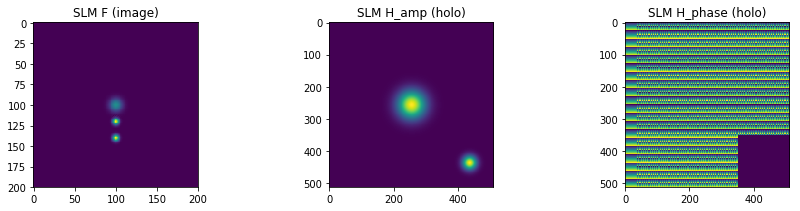

In [327]:
'''
We can also test the obvious: that only the phase of the illuminated parts of
the slm effect the pattern in the output plane.  This opens the possibilty of
illuminating each different areas of the slm to effectively use different
pixel blocks as separate slms.  
'''

def slm_phase_round(x,base=2*np.pi/256.0):
  return base * np.round(x/base)

def gaussian_2d(size, sigma):
    d = int(size/2)
    
    x, y = np.mgrid[-d:d+1, -d:d+1]
    g = np.exp(-(x**2+y**2)/(2*sigma**2))
    return g / g.max()

def add_gaussian_beam(H, pos, size, sigma, amp=1):
    d = int(size/2)
    if type(pos)==list: pos = np.array(pos)
    xmin,ymin = np.clip(pos-d,-256,256)
    xmax,ymax = np.clip(pos+d+1,-256,256)
    
    g = amp*gaussian_2d(size, sigma)

    H=H.astype(float)

    H[256+xmin:256+xmax,256+ymin:256+ymax] += g
    
    return H

'''
Define traps and make individual holo. planes
'''
nCycle_xyShifts = [(0,20),(0,40)]
n_traps = len(nCycle_xyShifts)

phase_grads = []
for nCycle_xyShift in nCycle_xyShifts:
    phase_grad_shifts = [2*np.pi*np.mod(np.arange(0,nCycle,nCycle/512),1) if nCycle!=0 
                         else np.zeros((1,512)) 
                         for nCycle in nCycle_xyShift]
    phase_grads.append([np.tile(phase_grad,(512,1)) 
                        for phase_grad in phase_grad_shifts])
    
#H_phase_grad = H_phase*phase_grad
H_phase_grads = [slm_phase_round(phase_grad_xShift + phase_grad_yShift.transpose())
                 for phase_grad_xShift, phase_grad_yShift in phase_grads]

H_phase_slm = H_phase_grads[0]

'''
Dither traps in x only
'''
k_max = int(np.ceil(len(H_phase_grads[1:])))  
for H in H_phase_grads[1:]:
    H_phase_slm[:,k::k_max+1] = H[:,k::k_max+1]
    k+=1
    
H_phase_slm[350:,350:]=np.zeros((162,162))+0

'''
Define SLM amplitude profile.
'''
H_amp_slm = np.zeros((512,512))

H_amp_slm = add_gaussian_beam(H_amp_slm, [0,0], 510, 30,amp=1)
H_amp_slm = add_gaussian_beam(H_amp_slm, [180,180], 510/5, 15,amp=1)
# H_amp_slm = add_gaussian_beam(H_amp_slm, [-128,-128], 510/2, 30)
# H_amp_slm = add_gaussian_beam(H_amp_slm, [128,-128], 510/2, 30)
# H_amp_slm = add_gaussian_beam(H_amp_slm, [-128,128], 510/2, 30)

'''
Define map holo plane --> image plane
'''
H_slm = H_amp_slm * np.exp(i*H_phase_slm)
F_slm = fft_HtoF(H_slm)

'''
Produce plots
'''
plt.figure(figsize=(15,15))

dZoom = 100

plt.subplot(1, 3, 1)
plt.imshow(np.abs(F_slm[
                    256-dZoom:256+dZoom,
                    256-dZoom:256+dZoom])**1
           )
plt.title("SLM F (image)")

plt.subplot(1, 3, 2)
plt.imshow(H_amp_slm
                    # 256-dx:256+dx,
                    # 256-dy:256+dy]
           )
plt.title("SLM H_amp (holo)")

plt.subplot(1, 3, 3)
plt.imshow(H_phase_slm
                    # 256-dx:256+dx,
                    # 256-dy:256+dy]
           )
plt.title("SLM H_phase (holo)")

plt.subplots_adjust(left=0.2, wspace=0.8, top=1)

plt.show()

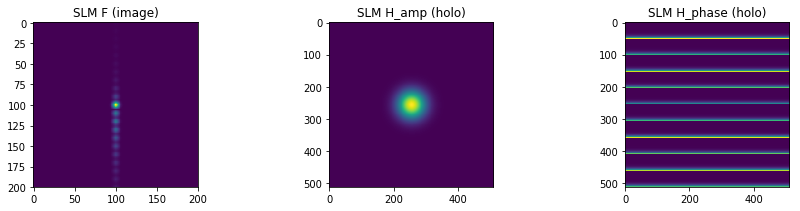

In [293]:
'''
We now show that applying a phase gradient across the slm effectively shifts
the diffraction orders in the fourier plane.

Thus by applying gradients in 2d we can individually move single traps around!
'''

def slm_phase_round(x,base=2*np.pi/256.0):
  return base * np.round(x/base)

def gaussian_2d(size, sigma):
    d = int(size/2)
    
    x, y = np.mgrid[-d:d+1, -d:d+1]
    g = np.exp(-(x**2+y**2)/(2*sigma**2))
    return g / g.max()

def add_gaussian_beam(H, pos, size, sigma, amp=1):
    d = int(size/2)
    if type(pos)==list: pos = np.array(pos)
    xmin,ymin = np.clip(pos-d,-256,256)
    xmax,ymax = np.clip(pos+d+1,-256,256)
    
    g = amp*gaussian_2d(size, sigma)

    H=H.astype(float)

    H[256+xmin:256+xmax,256+ymin:256+ymax] = g
    
    return H

'''
Define traps and make individual holo. planes
'''
nCycle_xyShifts = [(0,10)]
n_traps = len(nCycle_xyShifts)

phase_grads = []
for nCycle_xyShift in nCycle_xyShifts:
    phase_grad_shifts = [2*np.pi*((np.mod(np.arange(0,nCycle,nCycle/512),1)))**1 if nCycle!=0 
                         else np.zeros((1,512)) 
                         for nCycle in nCycle_xyShift]
    phase_grads.append([np.tile(phase_grad,(512,1)) 
                        for phase_grad in phase_grad_shifts])
    
#H_phase_grad = H_phase*phase_grad
H_phase_grads = [slm_phase_round(phase_grad_xShift + phase_grad_yShift.transpose())
                 for phase_grad_xShift, phase_grad_yShift in phase_grads]

H_phase_slm = H_phase_grads[0]

'''
Dither traps alternatley in x and y
'''
# k_max = int(np.ceil(len(H_phase_grads[1:])/2))
# l_max = k_max
# k,l=0,0
#
# for H1, H2 in itertools.zip_longest( H_phase_grads[1::2], H_phase_grads[2::2] ):
#     if type(H1)==np.ndarray:
#         H_phase_slm[:,k::k_max+1] = H1[:,k::k_max+1]
#         k+=1
# 
#     if type(H2)==np.ndarray:
#         H_phase_slm[l::l_max+1,:] = H2[l::l_max+1,:]
#         l+=1

'''
Dither traps in x only
'''
k_max = int(np.ceil(len(H_phase_grads[1:])))     
for H in H_phase_grads[1:]:
    H_phase_slm[:,k:int(k_max/2):k_max+1] = H[:,k:int(k_max/2):k_max+1]
    k+=1


'''
Define SLM amplitude profile.
'''
H_amp_slm = np.zeros((512,512))

H_amp_slm = add_gaussian_beam(H_amp_slm, [0,0], 510, 30,amp=1)
# H_amp_slm = add_gaussian_beam(H_amp_slm, [128,128], 510/2, 30)
# H_amp_slm = add_gaussian_beam(H_amp_slm, [-128,-128], 510/2, 30)
# H_amp_slm = add_gaussian_beam(H_amp_slm, [128,-128], 510/2, 30)
# H_amp_slm = add_gaussian_beam(H_amp_slm, [-128,128], 510/2, 30)

'''
Define map holo plane --> image plane
'''
H_slm = H_amp_slm * np.exp(i*H_phase_slm)
F_slm = fft_HtoF(H_slm)

'''
Produce plots
'''
plt.figure(figsize=(15,15))

plt.subplot(1, 3, 1)
plt.imshow(np.abs(F_slm
                    [256-100:256+100,
                     256-100:256+100])**1
           )
plt.title("SLM F (image)")

plt.subplot(1, 3, 2)
plt.imshow(H_amp_slm
                    # 256-dx:256+dx,
                    # 256-dy:256+dy]
           )
plt.title("SLM H_amp (holo)")

plt.subplot(1, 3, 3)
plt.imshow(H_phase_slm
                    # 256-dx:256+dx,
                    # 256-dy:256+dy]
           )
plt.title("SLM H_phase (holo)")

plt.subplots_adjust(left=0.2, wspace=0.8, top=1)

plt.show()

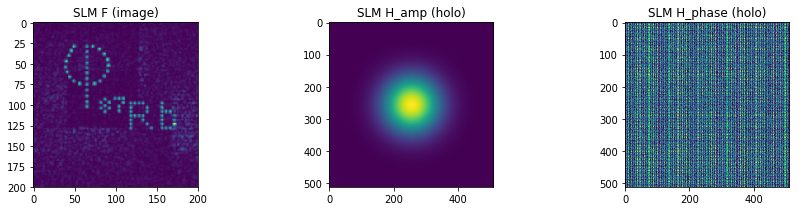

In [326]:
'''
Applying phase gradients to the trap patterns prior to dithering them still
allows even complex pre-calculated trap patterns to be individually moved
around.
'''

oxPhys_phases = np.genfromtxt('data/oxPhys_slm.txt', dtype=str, delimiter=' ')
Rb_phases = np.genfromtxt('data/87Rb_slm.txt', dtype=str, delimiter=' ')

[oxPhys_phases, Rb_phases] = [2*np.pi*phases.astype(float)*1/256 for phases in [oxPhys_phases, Rb_phases]]

nCycle_shifts = (40,60)
phase_grads = [2*np.pi*((np.mod(np.arange(0,nCycle,nCycle/512),1))) if nCycle!=0\
               else np.zeros((1,512))
               for nCycle in nCycle_shifts]
phase_grads = [np.tile(x,(512,1)) for x in phase_grads]

mix_phases = oxPhys_phases
mix_phases[:,::2] = Rb_phases[:,::2] + phase_grads[0][:,::2] + phase_grads[1].transpose()[:,::2]

H_phase_slm = mix_phases

'''
Define SLM amplitude profile.
'''
H_amp_slm = np.zeros((512,512))

H_amp_slm = add_gaussian_beam(H_amp_slm, [0,0], 510, 60,amp=1)

'''
Define map holo plane --> image plane
'''
H_slm = H_amp_slm * np.exp(i*H_phase_slm)
F_slm = fft_HtoF(H_slm)

'''
Produce plots
'''
plt.figure(figsize=(15,15))

plt.subplot(1, 3, 1)
plt.imshow(np.abs(F_slm[256-00:256+200,
                        256-00:256+200])
           )
plt.title("SLM F (image)")

plt.subplot(1, 3, 2)
plt.imshow(H_amp_slm
                    # 256-dx:256+dx,
                    # 256-dy:256+dy]
           )
plt.title("SLM H_amp (holo)")

plt.subplot(1, 3, 3)
plt.imshow(H_phase_slm
                    # 256-dx:256+dx,
                    # 256-dy:256+dy]
           )
plt.title("SLM H_phase (holo)")

plt.subplots_adjust(left=0.2, wspace=0.8, top=1)

plt.show()